In [ ]:
#Mika's part for experimentation

In [1]:
#imports
import pandas as pd
import numpy as np
import string
import torch
from tqdm.auto import tqdm

tqdm.pandas(desc='Progress')
import tensorflow

#PyTorch imports
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
from torch.autograd import Variable
from sklearn.metrics import f1_score
import torchtext
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn
import torch.nn.functional as F


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [11]:
#data preparation
path_data_sexist_comments = "/content/drive/MyDrive/COMP550 Final Project/ISEP Sexist Data labeling.xlsx"
path_data_amazon = "/content/drive/MyDrive/COMP550 Final Project/AmazonMini.csv"
path_data_imdb = "/content/drive/MyDrive/COMP550 Final Project/IMDB.csv"

#CHANGE to pd.read_csv FOR OTHER DATASETS :)) 
df_sexist = pd.read_excel(path_data_sexist_comments)
df_amazon = pd.read_csv(path_data_amazon)
df_imdb = pd.read_csv(path_data_imdb)

#path to Glove
path_glove = "/content/drive/MyDrive/COMP550 Final Project/glove.6B.50d.txt"

Pre-processing of the sexist comments dataset

In [7]:
#pre-process the sexist comment dataset
def lowerCase(StringArray):
    lowerArray = []
    for i in StringArray:
        lowerArray.append(i.lower())
    return lowerArray

def depunctuate(StringArray):
    exclude = set(string.punctuation)
    depStringArray = []
    for i in StringArray:
        s = ''.join(ch for ch in i if ch not in exclude)
        depStringArray.append(s)
    return depStringArray

data_sexist_sentences = df_sexist['Sentences'].to_numpy()

#lowercase the sentences
data_sexist_sentences = lowerCase(data_sexist_sentences)

#depunctuate
data_sexist_sentences = depunctuate(data_sexist_sentences)

#load the final data
df_sexist['Sentences'] = pd.Series(data_sexist_sentences)

In [8]:
#Bi-LSTM model
class BiLSTM(nn.Module):
    def __init__(self, args):
        super(BiLSTM, self).__init__()

        #size of input vectors, that'll be the embedding size
        self.hidden_dim = args['hidden_dim']

        #number of words in the vocabulary
        self.vocab_size = args['vocab_size']

        #number of classes you're predicting (usually binary)
        self.output_dim = args['output_dim']

        #input size is the size of each word/embedding
        self.input_size = args['input_size']

        #Dropout
        self.drp = nn.Dropout(args['drp'])

        #Embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.input_size)
        self.embedding.weight=nn.Parameter(torch.tensor(args['embedding_matrix'], dtype=torch.float32))
        self.embedding.weight.requires_grad=args['requires_grad']

        #Bi-LSTM
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_dim,
                            dropout = args['drp'],
                            num_layers=2,
                            batch_first=True,
                            bidirectional=True)
        
        self.linear = nn.Linear(self.hidden_dim*2, self.output_dim)

        #Softmax activation function
        self.act = nn.Sigmoid()

    #Here x is the input tensor with shape: [batch_size, sequence_length]
    #ie. number of training examples * number of words/training examples
    def forward(self, x):
        x = self.embedding(x)

        output, (h_n, c_n) = self.lstm(x)

        h_n = torch.cat((h_n[-2, :, :], h_n[-1, :, :]), dim=1)

        x = self.linear(h_n)

        x = self.act(x)

        x = torch.squeeze(x)
        return x

In [9]:
class CustomDataset(Dataset):
    #TO-DO: change path_to_excel to accept a full dataframe
    def __init__(self, df, path_to_glove, embedding_dimension, max_nb_words=None, max_seq_length=None):
        #here you could simply receive the dataset already with embedding matrix, index, and pre-processed text
        self.samples = []
        self.labels = []
        self.df = df
        self.path_to_glove = path_to_glove
        self.embedding_dimension = embedding_dimension

        #get in _init_dataset
        self.length = None
        self.embedding_matrix = None

        #None by default
        self.max_nb_words = max_nb_words
        self.max_seq_length=max_seq_length

        #initialize with method
        self._init_dataset()

    def __len__(self):
        return self.length

    #for a
    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

    #input np.array of sentences
    def preprocessing(self, np_dataset):
        return np_dataset

    def create_embedding_matrix(self, word_index, embedding_dict):
        embedding_m = np.zeros((len(word_index) + 1, self.embedding_dimension))
        for word, index in word_index.items():
            if word in embedding_dict:
                embedding_m[index] = embedding_dict[word]
        self.embedding_matrix = embedding_m

    def _init_dataset(self):
        #create the array of labels
        y = pd.Series.to_numpy(self.df['Label'])
        for i in y:
            self.labels.append(i)

        #returns rows have individual sentences, non-tokenized!
        X = self.preprocessing(pd.Series.to_numpy(self.df['Sentences']))

        #create the word embeddings
        embed_dict = {}
        with open(path_glove, 'r', encoding="utf8") as file:
            Lines = file.readlines()

            for line in Lines:
                values = line.split()
                word = values[0]

                try:
                    vector = np.asarray(values[1:], 'float32')
                except:
                    pass
                embed_dict[word] = vector

        if self.max_seq_length == None:
            self.max_seq_length = max(len(i.split()) for i in X)

        self.length = X.shape[0]

        #tokenize the next and put in array of integers, where each integer is mapped to a word
        np.random.seed(7)
        if self.max_nb_words != None:
            tokenizer = Tokenizer(num_words=self.max_nb_words)
        else:
            tokenizer = Tokenizer(num_words=len(embed_dict.keys()))

        #maybe move this into another method for efficiency's sake
        tokenizer.fit_on_texts(X)
        sequences = tokenizer.texts_to_sequences(X)
        word_index = tokenizer.word_index
        text = pad_sequences(sequences, maxlen=self.max_seq_length)
        indices = np.arange(self.length)
        text = text[indices]

        for i in text:
            self.samples.append(i)
        self.create_embedding_matrix(word_index=word_index, embedding_dict=embed_dict)

In [12]:
#load into validation and training dataset
#SEXIST
dataset_sexist = CustomDataset(df= df_sexist, path_to_glove=path_glove, embedding_dimension=50)
trainset_sexist, valset_sexist = random_split(dataset_sexist, [int(np.floor(len(dataset_sexist) * 0.8)), int(np.ceil(len(dataset_sexist) * 0.2))])

train_loader_sexist = DataLoader(trainset_sexist, batch_size=18, shuffle=True, num_workers=2)
val_loader_sexist = DataLoader(valset_sexist, batch_size=128, shuffle=True, num_workers=2)

#AMAZON
dataset_amazon = CustomDataset(df= df_amazon, path_to_glove=path_glove, embedding_dimension=50)
trainset_amazon, valset_amazon = random_split(dataset_amazon, [int(np.floor(len(dataset_amazon) * 0.7)), int(np.ceil(len(dataset_amazon) * 0.3))])

train_loader_amazon = DataLoader(trainset_amazon, batch_size=8, shuffle=True, num_workers=2)
val_loader_amazon = DataLoader(valset_amazon, batch_size=128, shuffle=True, num_workers=2)

#IMDB
dataset_imdb = CustomDataset(df= df_imdb, path_to_glove=path_glove, embedding_dimension=50)
trainset_imdb, valset_imdb = random_split(dataset_imdb, [int(np.floor(len(dataset_imdb) * 0.7)), int(np.ceil(len(dataset_imdb) * 0.3))])

train_loader_imdb = DataLoader(trainset_imdb, batch_size=8, shuffle=True, num_workers=2)
val_loader_imdb = DataLoader(valset_imdb, batch_size=128, shuffle=True, num_workers=2)

In [13]:
#fill the args dictionary with the required parameters
args = {
    'hidden_dim' : 32, #number of hidden dim
    'vocab_size' : dataset_sexist.embedding_matrix.shape[0], #number of rows in word embedding matrix
    'input_size' : 50,
    'output_dim' : 1, #number of classes you're predicting
    'embedding_matrix' : dataset_sexist.embedding_matrix, #the embedding matrix you've built in dataset constructor
    'drp' : 0.2, #dropout layer for forward LSTM
    'requires_grad': False, #for embedding matrix
}

Here we train the BiLSTM model with 5 epochs. We will do this ten times and then average the model's performance on the validation dataset with every new batch of batch_size points that it sees.

In [15]:
results_vanilla = {
    'accuracy_training': [],
    'loss': [],
    'accuracy_validation': []
}

for t in range(10):
    model = BiLSTM(args)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    training_score = []
    loss_score = []
    validation_score = []
    print(t)
    for e in range(5):
        for i, data in enumerate(train_loader_sexist):
            model.train()

            running_loss = 0
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optim.Adam(model.parameters(), lr=0.01).zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #Get the loss on the batch
            targets = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            
            loss = criterion(outputs, targets)

            #gets the gradient on the batch for each parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

            #take size lr step in gradient direction
            optimizer.step()
            total_acc = 0
            total_count = 0
            total_acc += (torch.round(outputs) == labels).sum().item()
            total_count += labels.size(0)

            # print statistics
            running_loss += loss.item()
            
            #validation
            model.eval()

            #set metrics to 0
            total_accuracy_val = 0
            total_count_val = 0

            for i_val, data_val in enumerate(val_loader_sexist):
                inputs_val, labels_val = data_val

                # forward + backward + optimize
                outputs_val = model(inputs_val)

                targets_val = labels_val.to(torch.float32)
                outputs_val = outputs_val.to(torch.float32)

                total_accuracy_val += (torch.round(outputs_val) == labels_val).sum().item()
                total_count_val += labels_val.size(0)
            
            training_score.append(total_acc/total_count)
            validation_score.append(total_accuracy_val/total_count_val)
            loss_score.append(running_loss/total_count)

            #print(f'acc_train: {total_acc/total_count} \| acc_val: {total_accuracy_val/total_count_val} \| avg_loss: {running_loss/total_count}')
            
            #set the metrics to 0
            running_loss = 0
            total_acc, total_count = 0, 0
    
    results_vanilla['accuracy_training'].append(training_score)
    results_vanilla['accuracy_validation'].append(validation_score)
    results_vanilla['loss'].append(loss_score)

0
1
2
3
4
5
6
7
8
9


In [18]:
results_avg = {
    'accuracy_training': [],
    'loss': [],
    'accuracy_validation': []
}
#get the averages during the training phases
for k,v in results_vanilla.items():
    score_raw = results_vanilla[k]
    score_avg = []
    for r in range(0, len(score_raw[0])):
        avg = 0
        for i in range(0, len(score_raw)):
            avg += score_raw[i][r]
        score_avg.append(avg)
    results_avg[k] = score_avg
print(results_avg)
print(results_vanilla)

{'accuracy_training': [4.944444444444445, 5.111111111111111, 5.444444444444445, 5.388888888888888, 5.944444444444445, 5.277777777777778, 5.333333333333333, 6.055555555555556, 5.444444444444445, 5.277777777777778, 5.722222222222223, 5.500000000000001, 5.333333333333332, 5.555555555555555, 5.388888888888889, 5.444444444444444, 5.166666666666667, 5.222222222222222, 5.611111111111111, 5.888888888888888, 5.8888888888888875, 5.111111111111112, 6.111111111111111, 5.3888888888888875, 5.666666666666666, 5.611111111111111, 5.388888888888889, 5.222222222222222, 5.888888888888888, 5.666666666666667, 5.111111111111112, 6.333333333333334, 4.944444444444445, 6.555555555555555, 5.444444444444444, 6.333333333333333, 5.944444444444445, 6.222222222222222, 6.333333333333334, 6.166666666666667, 6.777777777777779, 5.722222222222222, 6.555555555555556, 6.444444444444445, 6.333333333333332, 7.166666666666668, 6.944444444444444, 7.111111111111111, 6.388888888888889, 7.000000000000001, 7.0, 7.333333333333333, 7

Evaluate the Bi-LSTM model, we reach a score of around 82% on the test set!

In [ ]:
model.eval()
total_acc = 0
total_count = 0
for _, d in enumerate(val_loader_sexist):
    inputs, labels = d
    outputs = model(inputs)

    # forward + backward + optimize
    outputs = model(inputs)

    targets = labels.to(torch.float32)
    outputs = outputs.to(torch.float32)

    total_acc += (torch.round(outputs) == labels).sum().item()
    total_count += labels.size(0)

accuracy = total_acc/total_count
print(accuracy)

0.8114035087719298


Getting the MAML algorithm!

In [ ]:
#Embedding layers

#Sexist embedding layers
embedding_sexist = nn.Embedding(dataset_sexist.embedding_matrix.shape[0], 50)
embedding_sexist.weight=nn.Parameter(torch.tensor(dataset_sexist.embedding_matrix, dtype=torch.float32))

#Amazon embedding layers
embedding_amazon = nn.Embedding(dataset_amazon.embedding_matrix.shape[0], 50)
embedding_amazon.weight=nn.Parameter(torch.tensor(dataset_amazon.embedding_matrix, dtype=torch.float32))

#IMDB embedding layers
embedding_imdb = nn.Embedding(dataset_imdb.embedding_matrix.shape[0], 50)
embedding_imdb.weight=nn.Parameter(torch.tensor(dataset_imdb.embedding_matrix, dtype=torch.float32))

In [ ]:
from torch.optim.adam import Adam
import copy

class MAML():
    def __init__(self, epochs, inner_updates, loss_fn, inner_stepsize, meta_stepsize, dict_embeddings, args_learner, tasks_list, target_task) -> None:
        self.epochs = epochs
        self.inner_updates = inner_updates 
        self.learner = BiLSTM(args_learner)
        self.loss_fn = loss_fn
        self.inner_stepsize = inner_stepsize
        self.meta_step_size = meta_stepsize
        self.embedding_dict = dict_embeddings
        self.tasks_list = tasks_list #list of (train_loader, val_loader, key)
        self.target_train_loader, self.target_val_loader, self.key = target_task #thruple (train_loader, val_loader, key)
        self.args_learner = args_learner
        self.results = [] #each position is the ith train call
        self.models = []
        self.eval = 0
        self.t = 0

    def evaluate(self, weights=None):
        print(f'Evaluation: {self.eval}')
        self.eval += 1
        #Create result dict at this evaluation position
        results = {
            'loss' : [],
            'accuracy_training': [],
            'accuracy_validation' : []
        }
        if weights == None:
            # Make a copy of the model
            args = copy.deepcopy(self.args_learner)
            args['requires_grad'] = False
            model = BiLSTM(args)

            #load the state dict cause you'll be training, don't want to mess up the weights
            state_dict = copy.deepcopy(self.learner.state_dict())
            model.load_state_dict(state_dict)
        else:
            model = BiLSTM(args_learner)
            model.load(weights)

        # Train
        #for e in range(5):
        for i, data in enumerate(self.target_train_loader):
            if i == 4:
                break
            model.train()
            running_loss = 0
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optim.Adam(model.parameters(), lr=0.01).zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #Get the loss on the batch
            targets = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            
            loss = self.loss_fn(outputs, targets)

            #gets the gradient on the batch for each parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

            #take size lr step in gradient direction
            optim.Adam(model.parameters(), lr=0.01).step()
            total_acc = 0
            total_count = 0
            total_acc += (torch.round(outputs) == labels).sum().item()
            total_count += labels.size(0)

            # print statistics
            running_loss += loss.item()
            
            #validation
            model.eval()

            #set metrics to 0
            total_accuracy_val = 0
            total_count_val = 0

            for i_val, data_val in enumerate(self.target_val_loader):
                inputs_val, labels_val = data_val

                # forward + backward + optimize
                outputs_val = model(inputs_val)

                targets_val = labels_val.to(torch.float32)
                outputs_val = outputs_val.to(torch.float32)

                total_accuracy_val += (torch.round(outputs_val) == labels_val).sum().item()
                total_count_val += labels_val.size(0)
            
            results['accuracy_training'].append(total_acc/total_count)
            results['accuracy_validation'].append(total_accuracy_val/total_count_val)
            results['loss'].append(running_loss/total_count)

            #print(f'acc_train: {total_acc/total_count} \| acc_val: {total_accuracy_val/total_count_val} \| avg_loss: {running_loss/total_count}')
            
            #set the metrics to 0
            running_loss = 0
            total_acc, total_count = 0, 0

        self.results.append({'results':results, 't': self.t, 'i': i, 'model_state_val': copy.deepcopy(model.state_dict()), 'model_state': copy.deepcopy(self.learner.state_dict())})

        print(max(results['accuracy_validation']), i)
        return model.state_dict()

    def maml_loop(self):
        print(f'Start_train: {self.t}')
        self.t += 1
        grads = []
        #this is the meta loop, could sample from the # of tasks
        for (train, val, key) in self.tasks_list:
            #create a new model for gradient update in inner loop
            #this is just to keep track of the gradien update
            new_model = BiLSTM(self.args_learner)
            state_dict = copy.deepcopy(self.learner.state_dict())

            #load the correct embedding
            new_model._modules['embedding'] = self.embedding_dict[key]
            state_dict['embedding.weight'] = self.embedding_dict[key].weight

            new_model.load_state_dict(state_dict)
            

            #run the inner loop on the new model for a given task
            #just to keep track
            fast_weights = dict((name, param) for (name, param) in new_model.named_parameters())

            for updates in range(self.inner_updates):
                in_, target = train.__iter__().next()

                out = new_model.forward(in_)

                out = out.to(torch.float32)
                target = target.to(torch.float32)

                #fix issue for cross entropy, maybe fixes the other issue about auto_grad
                loss = self.loss_fn(out, target)
                #get the gradient for task
                g = torch.autograd.grad(loss, new_model.parameters(), create_graph=True)

                #zero the embedding gradients since we're not learning those
                g = tuple(g[i] if i != 0 else torch.zeros(g[0].shape, requires_grad=True) for i in range(len(g)))

                #update weights
                fast_weights = dict((name, param - self.inner_stepsize * g) for ((name, param), g) in zip(fast_weights.items(), g))

                #load those weights into the new_model, embedding weights is the same
                new_model.load_state_dict(fast_weights)

            #Test the net after training
            #write some print statements for sanity checks

            #compute the meta_gradient on val and return it
            in_, target = val.__iter__().next()
            out = new_model.forward(in_)
            out = out.to(torch.float32)
            target = target.to(torch.float32)

            #fix issue for cross entropy, maybe fixes the other issue about auto_grad
            loss = self.loss_fn(out, target)

            #normalizes the loss over the batch size
            loss = loss / len(tasks_list)

            g = torch.autograd.grad(loss, new_model.parameters(), create_graph=True)

            #zero the gradients
            #set to the learner model embedding weights
            learner_embedding_size = copy.deepcopy(self.learner.state_dict())
            learner_embedding_size = learner_embedding_size['embedding.weight'].shape
            g = tuple(g[i] if i != 0 else torch.zeros(learner_embedding_size, requires_grad=True) for i in range(len(g)))

            meta_grads = {name:g for ((name, _), g) in zip(new_model.named_parameters(), g)}

            #pass the meta-task gradients to the 
            grads.append(meta_grads)
            
        #load new task completely for dummy, this task is the target task
        in_, target = self.target_train_loader.__iter__().next()

        # Do a dummy forward/backward pass to get correct grads into learner
        # We will be replacing the gradients with hooks regardless
        out = self.learner.forward(in_)
        out = out.to(torch.float32)
        target = target.to(torch.float32)
        loss = self.loss_fn(out, target)

        loss.backward(retain_graph=True)

        # Unpack the gradients from dictionary of meta-gradients
        gradients = {k: sum(d[k] for d in grads) for k in grads[0].keys()}
        
        hooks = []
        for(k,v) in self.learner.named_parameters():
            def get_closure():
                key = k
                def replace_grad(grad):
                    return gradients[key]
                return replace_grad
            hooks.append(v.register_hook(get_closure()))
        
        # Compute grads for current step, replace with summed gradients as defined by hook
        # DO DOUBLE CHECK THAT THE GRADIENTS ARE BEING UPDATED CORRECTLY WITH HOOKS
        optim.Adam(self.learner.parameters(), lr=self.meta_step_size).zero_grad()
        loss.backward()

        # Update the net parameters with the accumulated gradient according to optimizer
        optim.Adam(self.learner.parameters(), lr=self.meta_step_size).step()

        # Remove the hooks before next training phase
        for h in hooks:
            h.remove()

        #save the state dict so it can be used later
        self.models.append(copy.deepcopy(self.learner.state_dict()))

Below are the arguments for the BiLSTM model which we will use as a learner model in the MAML meta-learning algorithm

In [ ]:
tasks_list = [(train_loader_amazon, val_loader_amazon, 'amazon'), (train_loader_imdb, val_loader_imdb, 'imdb')]

embedding_dict = {
    'sexist': embedding_sexist,
    'amazon': embedding_amazon,
    'imdb': embedding_imdb,
}

# Here we will be changing the input matrix embedding with every different dataset so we set required_grad to True
args_learner = {
           'hidden_dim' : 32, #number of hidden dim
           'vocab_size' : dataset_sexist.embedding_matrix.shape[0], #number of rows in word embedding matrix
           'input_size' : 50,
           'output_dim' : 1, #number of classes you're predicting
           'embedding_matrix' : dataset_sexist.embedding_matrix, #the embedding matrix you've built in dataset constructor
           'drp' : 0.2, #dropout layer for forward LSTM
           'requires_grad': True,
    }

Here we get the average of the results of the learner model train with MAML. We use this to determine how many iterations are required to get a good meta-trained model. 

In [ ]:
results = []

#mother of all experiments
#get 10 values for this step size
#this gave us the below strings

for lr in range(10):
    maml = MAML(epochs=15, 
    inner_updates=2, 
    loss_fn=nn.BCELoss(), 
    inner_stepsize=0.01, 
    meta_stepsize=0.001, 
    dict_embeddings=embedding_dict, 
    args_learner=args_learner, 
    tasks_list = tasks_list, 
    target_task = (train_loader_sexist, val_loader_sexist, 'sexist'))

    for i in range(50):
        maml.maml_loop()
        maml.evaluate()
    results.append(copy.deepcopy(maml.results))

In [ ]:
#save the model

#save with optimal params
optimal_val = results[36]['model_state_val']
optimal_state = results[36]['model_state']
torch.save(optimal_val, "/content/drive/MyDrive/COMP550 Final Project/Models/Optimal Parameters/model_state_val")
torch.save(optimal_state, "/content/drive/MyDrive/COMP550 Final Project/Models/Optimal Parameters/model_state")

#save with best, it was model after 36 iterations
best_val = results[36]['model_state_val']
best_state = results[36]['model_state']
torch.save(best_val, "/content/drive/MyDrive/COMP550 Final Project/Models/Best/model_state_val")
torch.save(best_state, "/content/drive/MyDrive/COMP550 Final Project/Models/Best/model_state")

*Plotting*


In [ ]:
def process_strings(s):
    for i in range(50):
        s = s.replace(f'Start_train: {i} Evaluation: {i}', '')
    s = s.split(' 4')
    s = [i.replace(' ', '') for i in s]
    s.pop()
    s = [float(i) for i in s]

    return s

Below are the results of the loop which found the best number of loops to train the meta-learner

In [ ]:
c1 = "Start_train: 0 Evaluation: 0 0.6096491228070176 4 Start_train: 1 Evaluation: 1 0.7017543859649122 4 Start_train: 2 Evaluation: 2 0.5570175438596491 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5701754385964912 4 Start_train: 5 Evaluation: 5 0.5921052631578947 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.5789473684210527 4 Start_train: 8 Evaluation: 8 0.5570175438596491 4 Start_train: 9 Evaluation: 9 0.5570175438596491 4 Start_train: 10 Evaluation: 10 0.5877192982456141 4 Start_train: 11 Evaluation: 11 0.5570175438596491 4 Start_train: 12 Evaluation: 12 0.5570175438596491 4 Start_train: 13 Evaluation: 13 0.618421052631579 4 Start_train: 14 Evaluation: 14 0.5570175438596491 4 Start_train: 15 Evaluation: 15 0.6929824561403509 4 Start_train: 16 Evaluation: 16 0.618421052631579 4 Start_train: 17 Evaluation: 17 0.6973684210526315 4 Start_train: 18 Evaluation: 18 0.5570175438596491 4 Start_train: 19 Evaluation: 19 0.5745614035087719 4 Start_train: 20 Evaluation: 20 0.706140350877193 4 Start_train: 21 Evaluation: 21 0.6973684210526315 4 Start_train: 22 Evaluation: 22 0.5570175438596491 4 Start_train: 23 Evaluation: 23 0.7149122807017544 4 Start_train: 24 Evaluation: 24 0.6491228070175439 4 Start_train: 25 Evaluation: 25 0.5657894736842105 4 Start_train: 26 Evaluation: 26 0.5657894736842105 4 Start_train: 27 Evaluation: 27 0.6140350877192983 4 Start_train: 28 Evaluation: 28 0.6929824561403509 4 Start_train: 29 Evaluation: 29 0.6798245614035088 4 Start_train: 30 Evaluation: 30 0.6842105263157895 4 Start_train: 31 Evaluation: 31 0.5570175438596491 4 Start_train: 32 Evaluation: 32 0.5789473684210527 4 Start_train: 33 Evaluation: 33 0.5570175438596491 4 Start_train: 34 Evaluation: 34 0.5657894736842105 4 Start_train: 35 Evaluation: 35 0.5833333333333334 4 Start_train: 36 Evaluation: 36 0.6666666666666666 4 Start_train: 37 Evaluation: 37 0.631578947368421 4 Start_train: 38 Evaluation: 38 0.6842105263157895 4 Start_train: 39 Evaluation: 39 0.6228070175438597 4 Start_train: 40 Evaluation: 40 0.6052631578947368 4 Start_train: 41 Evaluation: 41 0.6403508771929824 4 Start_train: 42 Evaluation: 42 0.5657894736842105 4 Start_train: 43 Evaluation: 43 0.6578947368421053 4 Start_train: 44 Evaluation: 44 0.5701754385964912 4 Start_train: 45 Evaluation: 45 0.5833333333333334 4 Start_train: 46 Evaluation: 46 0.5570175438596491 4 Start_train: 47 Evaluation: 47 0.5570175438596491 4 Start_train: 48 Evaluation: 48 0.5745614035087719 4 Start_train: 49 Evaluation: 49 0.7017543859649122 4"
c2 = "Start_train: 0 Evaluation: 0 0.5614035087719298 4 Start_train: 1 Evaluation: 1 0.6403508771929824 4 Start_train: 2 Evaluation: 2 0.5570175438596491 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.5570175438596491 4 Start_train: 6 Evaluation: 6 0.6885964912280702 4 Start_train: 7 Evaluation: 7 0.5570175438596491 4 Start_train: 8 Evaluation: 8 0.6271929824561403 4 Start_train: 9 Evaluation: 9 0.631578947368421 4 Start_train: 10 Evaluation: 10 0.5570175438596491 4 Start_train: 11 Evaluation: 11 0.7149122807017544 4 Start_train: 12 Evaluation: 12 0.618421052631579 4 Start_train: 13 Evaluation: 13 0.44298245614035087 4 Start_train: 14 Evaluation: 14 0.5570175438596491 4 Start_train: 15 Evaluation: 15 0.5701754385964912 4 Start_train: 16 Evaluation: 16 0.5570175438596491 4 Start_train: 17 Evaluation: 17 0.6535087719298246 4 Start_train: 18 Evaluation: 18 0.6535087719298246 4 Start_train: 19 Evaluation: 19 0.6447368421052632 4 Start_train: 20 Evaluation: 20 0.5570175438596491 4 Start_train: 21 Evaluation: 21 0.5921052631578947 4 Start_train: 22 Evaluation: 22 0.6842105263157895 4 Start_train: 23 Evaluation: 23 0.7236842105263158 4 Start_train: 24 Evaluation: 24 0.6447368421052632 4 Start_train: 25 Evaluation: 25 0.5921052631578947 4 Start_train: 26 Evaluation: 26 0.6622807017543859 4 Start_train: 27 Evaluation: 27 0.5570175438596491 4 Start_train: 28 Evaluation: 28 0.5570175438596491 4 Start_train: 29 Evaluation: 29 0.6447368421052632 4 Start_train: 30 Evaluation: 30 0.5614035087719298 4 Start_train: 31 Evaluation: 31 0.6622807017543859 4 Start_train: 32 Evaluation: 32 0.6403508771929824 4 Start_train: 33 Evaluation: 33 0.6008771929824561 4 Start_train: 34 Evaluation: 34 0.6754385964912281 4 Start_train: 35 Evaluation: 35 0.7236842105263158 4 Start_train: 36 Evaluation: 36 0.5657894736842105 4 Start_train: 37 Evaluation: 37 0.5701754385964912 4 Start_train: 38 Evaluation: 38 0.5570175438596491 4 Start_train: 39 Evaluation: 39 0.5657894736842105 4 Start_train: 40 Evaluation: 40 0.6798245614035088 4 Start_train: 41 Evaluation: 41 0.5657894736842105 4 Start_train: 42 Evaluation: 42 0.5701754385964912 4 Start_train: 43 Evaluation: 43 0.5614035087719298 4 Start_train: 44 Evaluation: 44 0.7105263157894737 4 Start_train: 45 Evaluation: 45 0.5833333333333334 4 Start_train: 46 Evaluation: 46 0.5833333333333334 4 Start_train: 47 Evaluation: 47 0.5657894736842105 4 Start_train: 48 Evaluation: 48 0.6842105263157895 4 Start_train: 49 Evaluation: 49 0.5964912280701754 4"
c3 = "Start_train: 0 Evaluation: 0 0.5570175438596491 4 Start_train: 1 Evaluation: 1 0.5570175438596491 4 Start_train: 2 Evaluation: 2 0.5570175438596491 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.5570175438596491 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.5745614035087719 4 Start_train: 8 Evaluation: 8 0.5570175438596491 4 Start_train: 9 Evaluation: 9 0.6929824561403509 4 Start_train: 10 Evaluation: 10 0.6973684210526315 4 Start_train: 11 Evaluation: 11 0.5745614035087719 4 Start_train: 12 Evaluation: 12 0.6228070175438597 4 Start_train: 13 Evaluation: 13 0.6754385964912281 4 Start_train: 14 Evaluation: 14 0.618421052631579 4 Start_train: 15 Evaluation: 15 0.5614035087719298 4 Start_train: 16 Evaluation: 16 0.5570175438596491 4 Start_train: 17 Evaluation: 17 0.6535087719298246 4 Start_train: 18 Evaluation: 18 0.7105263157894737 4 Start_train: 19 Evaluation: 19 0.5570175438596491 4 Start_train: 20 Evaluation: 20 0.706140350877193 4 Start_train: 21 Evaluation: 21 0.7017543859649122 4 Start_train: 22 Evaluation: 22 0.7412280701754386 4 Start_train: 23 Evaluation: 23 0.5570175438596491 4 Start_train: 24 Evaluation: 24 0.5570175438596491 4 Start_train: 25 Evaluation: 25 0.6578947368421053 4 Start_train: 26 Evaluation: 26 0.5570175438596491 4 Start_train: 27 Evaluation: 27 0.5570175438596491 4 Start_train: 28 Evaluation: 28 0.6842105263157895 4 Start_train: 29 Evaluation: 29 0.6491228070175439 4 Start_train: 30 Evaluation: 30 0.5570175438596491 4 Start_train: 31 Evaluation: 31 0.5570175438596491 4 Start_train: 32 Evaluation: 32 0.5833333333333334 4 Start_train: 33 Evaluation: 33 0.5789473684210527 4 Start_train: 34 Evaluation: 34 0.5570175438596491 4 Start_train: 35 Evaluation: 35 0.6666666666666666 4 Start_train: 36 Evaluation: 36 0.5570175438596491 4 Start_train: 37 Evaluation: 37 0.5570175438596491 4 Start_train: 38 Evaluation: 38 0.618421052631579 4 Start_train: 39 Evaluation: 39 0.5570175438596491 4 Start_train: 40 Evaluation: 40 0.5570175438596491 4 Start_train: 41 Evaluation: 41 0.6052631578947368 4 Start_train: 42 Evaluation: 42 0.5701754385964912 4 Start_train: 43 Evaluation: 43 0.6929824561403509 4 Start_train: 44 Evaluation: 44 0.6622807017543859 4 Start_train: 45 Evaluation: 45 0.6008771929824561 4 Start_train: 46 Evaluation: 46 0.7149122807017544 4 Start_train: 47 Evaluation: 47 0.6096491228070176 4 Start_train: 48 Evaluation: 48 0.5921052631578947 4 Start_train: 49 Evaluation: 49 0.631578947368421 4"
c4 = "Start_train: 0 Evaluation: 0 0.5570175438596491 4 Start_train: 1 Evaluation: 1 0.5570175438596491 4 Start_train: 2 Evaluation: 2 0.6622807017543859 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.5570175438596491 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.6535087719298246 4 Start_train: 8 Evaluation: 8 0.6535087719298246 4 Start_train: 9 Evaluation: 9 0.5570175438596491 4 Start_train: 10 Evaluation: 10 0.5570175438596491 4 Start_train: 11 Evaluation: 11 0.5570175438596491 4 Start_train: 12 Evaluation: 12 0.6008771929824561 4 Start_train: 13 Evaluation: 13 0.5570175438596491 4 Start_train: 14 Evaluation: 14 0.6798245614035088 4 Start_train: 15 Evaluation: 15 0.5570175438596491 4 Start_train: 16 Evaluation: 16 0.5570175438596491 4 Start_train: 17 Evaluation: 17 0.5570175438596491 4 Start_train: 18 Evaluation: 18 0.5570175438596491 4 Start_train: 19 Evaluation: 19 0.6885964912280702 4 Start_train: 20 Evaluation: 20 0.5570175438596491 4 Start_train: 21 Evaluation: 21 0.5570175438596491 4 Start_train: 22 Evaluation: 22 0.6052631578947368 4 Start_train: 23 Evaluation: 23 0.6578947368421053 4 Start_train: 24 Evaluation: 24 0.5701754385964912 4 Start_train: 25 Evaluation: 25 0.5570175438596491 4 Start_train: 26 Evaluation: 26 0.5570175438596491 4 Start_train: 27 Evaluation: 27 0.6140350877192983 4 Start_train: 28 Evaluation: 28 0.6885964912280702 4 Start_train: 29 Evaluation: 29 0.6578947368421053 4 Start_train: 30 Evaluation: 30 0.5570175438596491 4 Start_train: 31 Evaluation: 31 0.6008771929824561 4 Start_train: 32 Evaluation: 32 0.543859649122807 4 Start_train: 33 Evaluation: 33 0.5570175438596491 4 Start_train: 34 Evaluation: 34 0.6710526315789473 4 Start_train: 35 Evaluation: 35 0.5570175438596491 4 Start_train: 36 Evaluation: 36 0.5570175438596491 4 Start_train: 37 Evaluation: 37 0.6228070175438597 4 Start_train: 38 Evaluation: 38 0.5789473684210527 4 Start_train: 39 Evaluation: 39 0.7149122807017544 4 Start_train: 40 Evaluation: 40 0.5570175438596491 4 Start_train: 41 Evaluation: 41 0.5833333333333334 4 Start_train: 42 Evaluation: 42 0.6096491228070176 4 Start_train: 43 Evaluation: 43 0.6535087719298246 4 Start_train: 44 Evaluation: 44 0.6754385964912281 4 Start_train: 45 Evaluation: 45 0.6754385964912281 4 Start_train: 46 Evaluation: 46 0.5921052631578947 4 Start_train: 47 Evaluation: 47 0.706140350877193 4 Start_train: 48 Evaluation: 48 0.5657894736842105 4 Start_train: 49 Evaluation: 49 0.6973684210526315 4"
c5 = "Start_train: 0 Evaluation: 0 0.706140350877193 4 Start_train: 1 Evaluation: 1 0.6491228070175439 4 Start_train: 2 Evaluation: 2 0.5745614035087719 4 Start_train: 3 Evaluation: 3 0.6710526315789473 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.5877192982456141 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.5614035087719298 4 Start_train: 8 Evaluation: 8 0.5570175438596491 4 Start_train: 9 Evaluation: 9 0.6140350877192983 4 Start_train: 10 Evaluation: 10 0.5789473684210527 4 Start_train: 11 Evaluation: 11 0.5570175438596491 4 Start_train: 12 Evaluation: 12 0.5570175438596491 4 Start_train: 13 Evaluation: 13 0.5921052631578947 4 Start_train: 14 Evaluation: 14 0.5833333333333334 4 Start_train: 15 Evaluation: 15 0.7192982456140351 4 Start_train: 16 Evaluation: 16 0.5570175438596491 4 Start_train: 17 Evaluation: 17 0.6798245614035088 4 Start_train: 18 Evaluation: 18 0.618421052631579 4 Start_train: 19 Evaluation: 19 0.5570175438596491 4 Start_train: 20 Evaluation: 20 0.5745614035087719 4 Start_train: 21 Evaluation: 21 0.6578947368421053 4 Start_train: 22 Evaluation: 22 0.6271929824561403 4 Start_train: 23 Evaluation: 23 0.6535087719298246 4 Start_train: 24 Evaluation: 24 0.5570175438596491 4 Start_train: 25 Evaluation: 25 0.6578947368421053 4 Start_train: 26 Evaluation: 26 0.7149122807017544 4 Start_train: 27 Evaluation: 27 0.6535087719298246 4 Start_train: 28 Evaluation: 28 0.5657894736842105 4 Start_train: 29 Evaluation: 29 0.6052631578947368 4 Start_train: 30 Evaluation: 30 0.7236842105263158 4 Start_train: 31 Evaluation: 31 0.6228070175438597 4 Start_train: 32 Evaluation: 32 0.5657894736842105 4 Start_train: 33 Evaluation: 33 0.6403508771929824 4 Start_train: 34 Evaluation: 34 0.5701754385964912 4 Start_train: 35 Evaluation: 35 0.5570175438596491 4 Start_train: 36 Evaluation: 36 0.6403508771929824 4 Start_train: 37 Evaluation: 37 0.6710526315789473 4 Start_train: 38 Evaluation: 38 0.5877192982456141 4 Start_train: 39 Evaluation: 39 0.6008771929824561 4 Start_train: 40 Evaluation: 40 0.5570175438596491 4 Start_train: 41 Evaluation: 41 0.6973684210526315 4 Start_train: 42 Evaluation: 42 0.5614035087719298 4 Start_train: 43 Evaluation: 43 0.706140350877193 4 Start_train: 44 Evaluation: 44 0.6447368421052632 4 Start_train: 45 Evaluation: 45 0.6754385964912281 4 Start_train: 46 Evaluation: 46 0.5745614035087719 4 Start_train: 47 Evaluation: 47 0.6622807017543859 4 Start_train: 48 Evaluation: 48 0.5570175438596491 4 Start_train: 49 Evaluation: 49 0.5877192982456141 4"
c6 = "Start_train: 0 Evaluation: 0 0.6798245614035088 4 Start_train: 1 Evaluation: 1 0.7105263157894737 4 Start_train: 2 Evaluation: 2 0.5921052631578947 4 Start_train: 3 Evaluation: 3 0.7412280701754386 4 Start_train: 4 Evaluation: 4 0.6359649122807017 4 Start_train: 5 Evaluation: 5 0.6491228070175439 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.5570175438596491 4 Start_train: 8 Evaluation: 8 0.7192982456140351 4 Start_train: 9 Evaluation: 9 0.6403508771929824 4 Start_train: 10 Evaluation: 10 0.5657894736842105 4 Start_train: 11 Evaluation: 11 0.5570175438596491 4 Start_train: 12 Evaluation: 12 0.6710526315789473 4 Start_train: 13 Evaluation: 13 0.6228070175438597 4 Start_train: 14 Evaluation: 14 0.5570175438596491 4 Start_train: 15 Evaluation: 15 0.618421052631579 4 Start_train: 16 Evaluation: 16 0.5701754385964912 4 Start_train: 17 Evaluation: 17 0.6403508771929824 4 Start_train: 18 Evaluation: 18 0.5570175438596491 4 Start_train: 19 Evaluation: 19 0.5570175438596491 4 Start_train: 20 Evaluation: 20 0.7192982456140351 4 Start_train: 21 Evaluation: 21 0.6929824561403509 4 Start_train: 22 Evaluation: 22 0.5921052631578947 4 Start_train: 23 Evaluation: 23 0.5657894736842105 4 Start_train: 24 Evaluation: 24 0.5570175438596491 4 Start_train: 25 Evaluation: 25 0.6008771929824561 4 Start_train: 26 Evaluation: 26 0.6666666666666666 4 Start_train: 27 Evaluation: 27 0.5570175438596491 4 Start_train: 28 Evaluation: 28 0.5570175438596491 4 Start_train: 29 Evaluation: 29 0.6885964912280702 4 Start_train: 30 Evaluation: 30 0.7105263157894737 4 Start_train: 31 Evaluation: 31 0.5570175438596491 4 Start_train: 32 Evaluation: 32 0.7149122807017544 4 Start_train: 33 Evaluation: 33 0.5570175438596491 4 Start_train: 34 Evaluation: 34 0.5570175438596491 4 Start_train: 35 Evaluation: 35 0.5570175438596491 4 Start_train: 36 Evaluation: 36 0.5570175438596491 4 Start_train: 37 Evaluation: 37 0.5570175438596491 4 Start_train: 38 Evaluation: 38 0.6754385964912281 4 Start_train: 39 Evaluation: 39 0.5570175438596491 4 Start_train: 40 Evaluation: 40 0.5570175438596491 4 Start_train: 41 Evaluation: 41 0.6622807017543859 4 Start_train: 42 Evaluation: 42 0.6535087719298246 4 Start_train: 43 Evaluation: 43 0.7017543859649122 4 Start_train: 44 Evaluation: 44 0.6271929824561403 4 Start_train: 45 Evaluation: 45 0.6228070175438597 4 Start_train: 46 Evaluation: 46 0.5570175438596491 4 Start_train: 47 Evaluation: 47 0.7149122807017544 4 Start_train: 48 Evaluation: 48 0.6578947368421053 4 Start_train: 49 Evaluation: 49 0.6754385964912281 4"
c7 = "Start_train: 0 Evaluation: 0 0.5570175438596491 4 Start_train: 1 Evaluation: 1 0.5570175438596491 4 Start_train: 2 Evaluation: 2 0.7017543859649122 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.5570175438596491 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.6271929824561403 4 Start_train: 8 Evaluation: 8 0.6052631578947368 4 Start_train: 9 Evaluation: 9 0.6491228070175439 4 Start_train: 10 Evaluation: 10 0.5570175438596491 4 Start_train: 11 Evaluation: 11 0.5570175438596491 4 Start_train: 12 Evaluation: 12 0.6535087719298246 4 Start_train: 13 Evaluation: 13 0.6140350877192983 4 Start_train: 14 Evaluation: 14 0.6491228070175439 4 Start_train: 15 Evaluation: 15 0.5570175438596491 4 Start_train: 16 Evaluation: 16 0.7456140350877193 4 Start_train: 17 Evaluation: 17 0.7368421052631579 4 Start_train: 18 Evaluation: 18 0.5657894736842105 4 Start_train: 19 Evaluation: 19 0.6140350877192983 4 Start_train: 20 Evaluation: 20 0.6578947368421053 4 Start_train: 21 Evaluation: 21 0.5570175438596491 4 Start_train: 22 Evaluation: 22 0.5570175438596491 4 Start_train: 23 Evaluation: 23 0.5570175438596491 4 Start_train: 24 Evaluation: 24 0.5745614035087719 4 Start_train: 25 Evaluation: 25 0.5614035087719298 4 Start_train: 26 Evaluation: 26 0.6929824561403509 4 Start_train: 27 Evaluation: 27 0.6842105263157895 4 Start_train: 28 Evaluation: 28 0.6096491228070176 4 Start_train: 29 Evaluation: 29 0.7631578947368421 4 Start_train: 30 Evaluation: 30 0.6271929824561403 4 Start_train: 31 Evaluation: 31 0.6008771929824561 4 Start_train: 32 Evaluation: 32 0.706140350877193 4 Start_train: 33 Evaluation: 33 0.5570175438596491 4 Start_train: 34 Evaluation: 34 0.5921052631578947 4 Start_train: 35 Evaluation: 35 0.706140350877193 4 Start_train: 36 Evaluation: 36 0.5921052631578947 4 Start_train: 37 Evaluation: 37 0.6666666666666666 4 Start_train: 38 Evaluation: 38 0.5921052631578947 4 Start_train: 39 Evaluation: 39 0.6096491228070176 4 Start_train: 40 Evaluation: 40 0.6622807017543859 4 Start_train: 41 Evaluation: 41 0.5964912280701754 4 Start_train: 42 Evaluation: 42 0.7192982456140351 4 Start_train: 43 Evaluation: 43 0.5614035087719298 4 Start_train: 44 Evaluation: 44 0.6008771929824561 4 Start_train: 45 Evaluation: 45 0.5964912280701754 4 Start_train: 46 Evaluation: 46 0.7236842105263158 4 Start_train: 47 Evaluation: 47 0.5877192982456141 4 Start_train: 48 Evaluation: 48 0.5570175438596491 4 Start_train: 49 Evaluation: 49 0.5570175438596491 4"
c8 = "Start_train: 0 Evaluation: 0 0.5570175438596491 4 Start_train: 1 Evaluation: 1 0.5570175438596491 4 Start_train: 2 Evaluation: 2 0.7017543859649122 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.5570175438596491 4 Start_train: 6 Evaluation: 6 0.5570175438596491 4 Start_train: 7 Evaluation: 7 0.6271929824561403 4 Start_train: 8 Evaluation: 8 0.6052631578947368 4 Start_train: 9 Evaluation: 9 0.6491228070175439 4 Start_train: 10 Evaluation: 10 0.5570175438596491 4 Start_train: 11 Evaluation: 11 0.5570175438596491 4 Start_train: 12 Evaluation: 12 0.6535087719298246 4 Start_train: 13 Evaluation: 13 0.6140350877192983 4 Start_train: 14 Evaluation: 14 0.6491228070175439 4 Start_train: 15 Evaluation: 15 0.5570175438596491 4 Start_train: 16 Evaluation: 16 0.7456140350877193 4 Start_train: 17 Evaluation: 17 0.7368421052631579 4 Start_train: 18 Evaluation: 18 0.5657894736842105 4 Start_train: 19 Evaluation: 19 0.6140350877192983 4 Start_train: 20 Evaluation: 20 0.6578947368421053 4 Start_train: 21 Evaluation: 21 0.5570175438596491 4 Start_train: 22 Evaluation: 22 0.5570175438596491 4 Start_train: 23 Evaluation: 23 0.5570175438596491 4 Start_train: 24 Evaluation: 24 0.5745614035087719 4 Start_train: 25 Evaluation: 25 0.5614035087719298 4 Start_train: 26 Evaluation: 26 0.6929824561403509 4 Start_train: 27 Evaluation: 27 0.6842105263157895 4 Start_train: 28 Evaluation: 28 0.6096491228070176 4 Start_train: 29 Evaluation: 29 0.7631578947368421 4 Start_train: 30 Evaluation: 30 0.6271929824561403 4 Start_train: 31 Evaluation: 31 0.6008771929824561 4 Start_train: 32 Evaluation: 32 0.706140350877193 4 Start_train: 33 Evaluation: 33 0.5570175438596491 4 Start_train: 34 Evaluation: 34 0.5921052631578947 4 Start_train: 35 Evaluation: 35 0.706140350877193 4 Start_train: 36 Evaluation: 36 0.5921052631578947 4 Start_train: 37 Evaluation: 37 0.6666666666666666 4 Start_train: 38 Evaluation: 38 0.5921052631578947 4 Start_train: 39 Evaluation: 39 0.6096491228070176 4 Start_train: 40 Evaluation: 40 0.6622807017543859 4 Start_train: 41 Evaluation: 41 0.5964912280701754 4 Start_train: 42 Evaluation: 42 0.7192982456140351 4 Start_train: 43 Evaluation: 43 0.5614035087719298 4 Start_train: 44 Evaluation: 44 0.6008771929824561 4 Start_train: 45 Evaluation: 45 0.5964912280701754 4 Start_train: 46 Evaluation: 46 0.7236842105263158 4 Start_train: 47 Evaluation: 47 0.5877192982456141 4 Start_train: 48 Evaluation: 48 0.5570175438596491 4 Start_train: 49 Evaluation: 49 0.5570175438596491 4"
c9 = "Start_train: 0 Evaluation: 0 0.631578947368421 4 Start_train: 1 Evaluation: 1 0.7412280701754386 4 Start_train: 2 Evaluation: 2 0.5175438596491229 4 Start_train: 3 Evaluation: 3 0.6710526315789473 4 Start_train: 4 Evaluation: 4 0.6929824561403509 4 Start_train: 5 Evaluation: 5 0.6666666666666666 4 Start_train: 6 Evaluation: 6 0.7324561403508771 4 Start_train: 7 Evaluation: 7 0.5570175438596491 4 Start_train: 8 Evaluation: 8 0.5789473684210527 4 Start_train: 9 Evaluation: 9 0.5570175438596491 4 Start_train: 10 Evaluation: 10 0.7236842105263158 4 Start_train: 11 Evaluation: 11 0.6973684210526315 4 Start_train: 12 Evaluation: 12 0.6666666666666666 4 Start_train: 13 Evaluation: 13 0.5789473684210527 4 Start_train: 14 Evaluation: 14 0.6666666666666666 4 Start_train: 15 Evaluation: 15 0.7017543859649122 4 Start_train: 16 Evaluation: 16 0.6929824561403509 4 Start_train: 17 Evaluation: 17 0.5570175438596491 4 Start_train: 18 Evaluation: 18 0.706140350877193 4 Start_train: 19 Evaluation: 19 0.6666666666666666 4 Start_train: 20 Evaluation: 20 0.7280701754385965 4 Start_train: 21 Evaluation: 21 0.5833333333333334 4 Start_train: 22 Evaluation: 22 0.5570175438596491 4 Start_train: 23 Evaluation: 23 0.6973684210526315 4 Start_train: 24 Evaluation: 24 0.6710526315789473 4 Start_train: 25 Evaluation: 25 0.5570175438596491 4 Start_train: 26 Evaluation: 26 0.6359649122807017 4 Start_train: 27 Evaluation: 27 0.5833333333333334 4 Start_train: 28 Evaluation: 28 0.5570175438596491 4 Start_train: 29 Evaluation: 29 0.6491228070175439 4 Start_train: 30 Evaluation: 30 0.7105263157894737 4 Start_train: 31 Evaluation: 31 0.6885964912280702 4 Start_train: 32 Evaluation: 32 0.5964912280701754 4 Start_train: 33 Evaluation: 33 0.5701754385964912 4 Start_train: 34 Evaluation: 34 0.706140350877193 4 Start_train: 35 Evaluation: 35 0.5570175438596491 4 Start_train: 36 Evaluation: 36 0.6666666666666666 4 Start_train: 37 Evaluation: 37 0.7280701754385965 4 Start_train: 38 Evaluation: 38 0.5614035087719298 4 Start_train: 39 Evaluation: 39 0.5614035087719298 4 Start_train: 40 Evaluation: 40 0.6535087719298246 4 Start_train: 41 Evaluation: 41 0.5570175438596491 4 Start_train: 42 Evaluation: 42 0.5570175438596491 4 Start_train: 43 Evaluation: 43 0.5570175438596491 4 Start_train: 44 Evaluation: 44 0.6447368421052632 4 Start_train: 45 Evaluation: 45 0.5789473684210527 4 Start_train: 46 Evaluation: 46 0.706140350877193 4 Start_train: 47 Evaluation: 47 0.618421052631579 4 Start_train: 48 Evaluation: 48 0.5570175438596491 4 Start_train: 49 Evaluation: 49 0.6666666666666666 4"
c10 = "Start_train: 0 Evaluation: 0 0.5701754385964912 4 Start_train: 1 Evaluation: 1 0.5570175438596491 4 Start_train: 2 Evaluation: 2 0.5570175438596491 4 Start_train: 3 Evaluation: 3 0.5570175438596491 4 Start_train: 4 Evaluation: 4 0.5570175438596491 4 Start_train: 5 Evaluation: 5 0.6622807017543859 4 Start_train: 6 Evaluation: 6 0.5833333333333334 4 Start_train: 7 Evaluation: 7 0.45614035087719296 4 Start_train: 8 Evaluation: 8 0.5745614035087719 4 Start_train: 9 Evaluation: 9 0.6447368421052632 4 Start_train: 10 Evaluation: 10 0.6798245614035088 4 Start_train: 11 Evaluation: 11 0.618421052631579 4 Start_train: 12 Evaluation: 12 0.7149122807017544 4 Start_train: 13 Evaluation: 13 0.6271929824561403 4 Start_train: 14 Evaluation: 14 0.5570175438596491 4 Start_train: 15 Evaluation: 15 0.631578947368421 4 Start_train: 16 Evaluation: 16 0.6403508771929824 4 Start_train: 17 Evaluation: 17 0.6929824561403509 4 Start_train: 18 Evaluation: 18 0.6008771929824561 4 Start_train: 19 Evaluation: 19 0.5570175438596491 4 Start_train: 20 Evaluation: 20 0.7236842105263158 4 Start_train: 21 Evaluation: 21 0.6228070175438597 4 Start_train: 22 Evaluation: 22 0.5657894736842105 4 Start_train: 23 Evaluation: 23 0.6140350877192983 4 Start_train: 24 Evaluation: 24 0.5570175438596491 4 Start_train: 25 Evaluation: 25 0.706140350877193 4 Start_train: 26 Evaluation: 26 0.5614035087719298 4 Start_train: 27 Evaluation: 27 0.5614035087719298 4 Start_train: 28 Evaluation: 28 0.5614035087719298 4 Start_train: 29 Evaluation: 29 0.706140350877193 4 Start_train: 30 Evaluation: 30 0.5570175438596491 4 Start_train: 31 Evaluation: 31 0.7236842105263158 4 Start_train: 32 Evaluation: 32 0.7236842105263158 4 Start_train: 33 Evaluation: 33 0.6359649122807017 4 Start_train: 34 Evaluation: 34 0.5789473684210527 4 Start_train: 35 Evaluation: 35 0.5745614035087719 4 Start_train: 36 Evaluation: 36 0.5745614035087719 4 Start_train: 37 Evaluation: 37 0.5745614035087719 4 Start_train: 38 Evaluation: 38 0.7236842105263158 4 Start_train: 39 Evaluation: 39 0.5570175438596491 4 Start_train: 40 Evaluation: 40 0.618421052631579 4 Start_train: 41 Evaluation: 41 0.7192982456140351 4 Start_train: 42 Evaluation: 42 0.5570175438596491 4 Start_train: 43 Evaluation: 43 0.5570175438596491 4 Start_train: 44 Evaluation: 44 0.7017543859649122 4 Start_train: 45 Evaluation: 45 0.7236842105263158 4 Start_train: 46 Evaluation: 46 0.5921052631578947 4 Start_train: 47 Evaluation: 47 0.6271929824561403 4 Start_train: 48 Evaluation: 48 0.7105263157894737 4 Start_train: 49 Evaluation: 49 0.7280701754385965 4"

results_raw = [c1, c2, c3, c4, c5, c6, c7, c8, c9, c10]
results =[process_strings(i) for i in results_raw]

In [ ]:
averages = []

#get the average
for r in range(0, len(results[0])):
    num = 0
    for c in range(0, len(results)):
        num += results[c][r]
    num = num/len(results)
    averages.append(num)
print(averages)

[0.5986842105263157, 0.6228070175438595, 0.5978070175438596, 0.5982456140350877, 0.5798245614035087, 0.594298245614035, 0.5903508771929823, 0.575, 0.6035087719298247, 0.619298245614035, 0.606140350877193, 0.5947368421052631, 0.631578947368421, 0.5942982456140351, 0.6074561403508772, 0.6166666666666666, 0.6241228070175439, 0.6605263157894736, 0.6092105263157894, 0.6030701754385964, 0.6587719298245613, 0.6219298245614034, 0.6043859649122807, 0.6298245614035087, 0.5912280701754385, 0.6017543859649123, 0.6307017543859649, 0.606578947368421, 0.6083333333333332, 0.6807017543859649, 0.631578947368421, 0.6171052631578948, 0.6359649122807017, 0.581140350877193, 0.6065789473684211, 0.6188596491228069, 0.5969298245614035, 0.624561403508772, 0.6171052631578947, 0.5956140350877192, 0.6109649122807017, 0.6223684210526316, 0.6083333333333333, 0.6210526315789473, 0.643859649122807, 0.6236842105263158, 0.6324561403508772, 0.6236842105263157, 0.6013157894736841, 0.6399122807017544]


Plotted below is the best result of the Learner model trained with MAML, after having seen 64 datapoints once ie. let the model see 64 datapoints and test on the validation data.

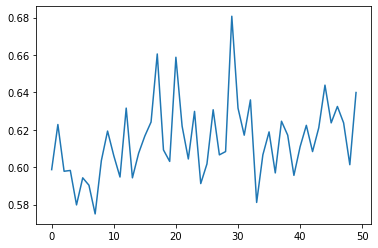

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(50)], averages)

2. Experimentation!

To-do:


*   Train vanilla on varying sizes of the training dataset and get numbers on the validation dataset
*   Train MAML updated on varying size of the training dataset and get numbers on the validation dataset

Uber time

In [ ]:
#input: - the model you want to test
#       - the dictionary in which you want to save the results
def experiment(model):
    results_experiment = {
    'accuracy_training': [],
    'loss': [],
    'accuracy_validation': []
}
    model = model
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    training_score = []
    loss_score = []
    validation_score = []

    for e in range(5):
        for i, data in enumerate(train_loader_sexist):
            model.train()

            running_loss = 0
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optim.Adam(model.parameters(), lr=0.01).zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            #Get the loss on the batch
            targets = labels.to(torch.float32)
            outputs = outputs.to(torch.float32)
            
            loss = criterion(outputs, targets)

            #gets the gradient on the batch for each parameter
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

            #take size lr step in gradient direction
            optimizer.step()
            total_acc = 0
            total_count = 0
            total_acc += (torch.round(outputs) == labels).sum().item()
            total_count += labels.size(0)

            # print statistics
            running_loss += loss.item()
            
            #validation
            model.eval()

            #set metrics to 0
            total_accuracy_val = 0
            total_count_val = 0

            for i_val, data_val in enumerate(val_loader_sexist):
                inputs_val, labels_val = data_val

                # forward + backward + optimize
                outputs_val = model(inputs_val)

                targets_val = labels_val.to(torch.float32)
                outputs_val = outputs_val.to(torch.float32)

                total_accuracy_val += (torch.round(outputs_val) == labels_val).sum().item()
                total_count_val += labels_val.size(0)
            
            training_score.append(total_acc/total_count)
            validation_score.append(total_accuracy_val/total_count_val)
            loss_score.append(running_loss/total_count)

            #print(f'acc_train: {total_acc/total_count} \| acc_val: {total_accuracy_val/total_count_val} \| avg_loss: {running_loss/total_count}')
            
            #set the metrics to 0
            running_loss = 0
            total_acc, total_count = 0, 0

    results_experiment['accuracy_training'].append(training_score)
    results_experiment['accuracy_validation'].append(validation_score)
    results_experiment['loss'].append(loss_score)

    return results_experiment

In [ ]:
embedding_matrix = torch.load("/content/drive/MyDrive/COMP550 Final Project/Models/Optimal Parameters/model_state")['embedding.weight']

#fill the args dictionary with the required parameters
args_model = {
    'hidden_dim' : 32, #number of hidden dim
    'vocab_size' : embedding_matrix.shape[0], #number of rows in word embedding matrix
    'input_size' : 50,
    'output_dim' : 1, #number of classes you're predicting
    'embedding_matrix' : embedding_matrix, #the embedding matrix you've built in dataset constructor
    'drp' : 0.2, #dropout layer for forward LSTM
    'requires_grad': False,
}

#create the MAML model
maml_trained_model = BiLSTM(args_model)
maml_trained_model = maml_trained_model.load_state_dict(torch.load("/content/drive/MyDrive/COMP550 Final Project/Models/Optimal Parameters/model_state"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
maml_trained_model.parameters()

AttributeError: ignored

In [ ]:
results_experiment = experiment(maml_trained_model)

AttributeError: ignored

In [ ]:
plt.plot()